In [ ]:
import torch
from torch import nn
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing, radius_graph, knn_graph
from torch_geometric.utils import remove_self_loops
from torch_scatter.scatter import scatter
from torch_scatter import scatter_min, scatter_max
from torch_cluster import knn
import matplotlib.pyplot as plt
from torch_cluster import fps
import pandas as pd
from models.gpgin import ConvLayer, MLP
from torch.nn.functional import silu
from torch_geometric.typing import (
    Adj,
    OptTensor,
    SparseTensor,
    pyg_lib,
    torch_sparse,
)
from typing import Tuple, List, Dict, Union
from pprint import pprint
from torch_geometric.data import Data, DataListLoader, Dataset, InMemoryDataset, Batch
from torch_geometric.loader import DataListLoader, DataLoader
from torch_geometric.nn import *
from torch_geometric.utils import to_dense_adj, to_dense_batch, add_self_loops, remove_self_loops
from torch_geometric.nn.conv import MessagePassing
import torch
from torch import nn
import rdkit
from tqdm.auto import tqdm
import itertools
from rdkit import Chem
import pandas as pd
from importlib import reload
import matplotlib.pyplot as plt
from rdkit import RDLogger

from copy import deepcopy
#from torch.utils.data import Dataset, DataLoader
from typing import Tuple, List, Dict, Union
from torch import Tensor
from torch_geometric.nn import MessagePassing, radius_graph
from torch_geometric.utils import add_self_loops, degree
from torch_scatter import scatter
from torch_geometric.typing import (
    Adj,
    OptTensor,
    SparseTensor,
    pyg_lib,
    torch_sparse,
)
from torch_geometric.data import (
    Data,
    InMemoryDataset,
    download_url,
    extract_zip,
)
from rdkit import Chem
import os
# Suppress RDKit warnings
RDLogger.DisableLog('rdApp.*')
cuda=torch.device('cuda') if torch.cuda.is_available() else 'cpu'
import sascorer
#torch.set_default_dtype(torch.float64)
from models import *
from rdkit.Chem.Crippen import MolLogP
from typing import List
from prolog import *
import torchlens as tl

In [2]:
sup=Chem.SDMolSupplier("datasets/qm9/raw/gdb9.sdf")

In [3]:
qm9=QM9("datasets/qm9")

C:\Users\labio\micromamba\envs\biocheminformatics\Lib\site-packages\torch_geometric\io\fs.py:229: UserWarning: Weights only load failed. Please file an issue to make `torch.load(weights_only=True)` compatible in your case. Please use `torch.serialization.add_safe_globals([MolData])` to allowlist this global.
  warnings.warn(f"{warn_msg} Please use "


In [4]:
qm9[0]

MolData(edge_index=[2, 1], pos=[1, 3], atom_type=[1], edge_type=[1], dist=[1, 1], D=[1, 3], U=[1, 3], V=[1, 3], logp=[1], u298_atom=[1], h298_atom=[1], r2=[1], u0=[1], lumo=[1], alpha=[1], cv=[1], B=[1], zpve=[1], A=[1], u298=[1], C=[1], gap=[1], h298=[1], homo=[1], u0_atom=[1], g298_atom=[1], mu=[1], g298=[1], dest=[0], inbound=[0, 2], ang_deltas=[0], anchor_ang=[0])

In [5]:
TEST_SIZE=1024
train_dataset, test_dataset = torch.utils.data.random_split(qm9, [len(qm9)-TEST_SIZE, TEST_SIZE])

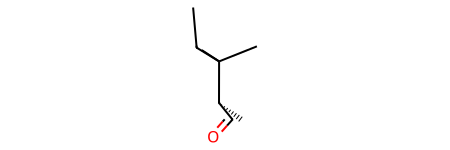

In [6]:
sample_idx=100_000
sample=qm9[sample_idx]
sup[sample_idx]

In [7]:
# example
show(sup[sample_idx])  # or 'P'

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [8]:
class TrainingContext:
    def __init__(self, cls, *args, **kwargs):
        self.inner = cls(*args, **kwargs).to(cuda)
        self.name = cls.__name__
        self.optim = torch.optim.AdamW(self.inner.parameters())
        self.sched = torch.optim.lr_scheduler.ExponentialLR(self.optim, gamma=0.98)
        self.num_parameters = sum(map(torch.numel,self.inner.parameters()))
        self.train_loss_record = dict()
        self.test_loss_record = dict()
        self.results = list()
        self.total_iters = 0
        self.running_loss = 0
        self.best_eval_loss = 999999
        self.stopped = False
        self.batch_size=32
        self.train_loss_metric='MSE'
        self.eval_loss_metric='MAE'
        self.last_target_name='normalized_u0'
        self.last_dataset_name='QM9'
        self.training=True
    def save(self, prefix='saves'):
        save_model(
            self.name,
            self.inner,
            optimizer=self.optim,
            scheduler=self.sched,
            loss_record={
                'train':self.train_loss_record,
                'test':self.test_loss_record,
            },
            total_training_iters=self.total_iters,
            last_batch_size=self.batch_size,
            loss_metric={
                'train':'MSE',
                'test':'MAE',
            },
            last_target_name=self.last_target_name,
            last_dataset_name=self.last_dataset_name
        )
    @classmethod
    def load(cls, name, class_, prefix='saves', training=False, override=None):
        if override is None:
            override=dict()
        checkpoint=torch.load(os.path.join(prefix,name,'checkpoint.pth'))
        self=cls(class_,**dict(**checkpoint['config'],**override))
        self.inner.load_state_dict(checkpoint['model_state_dict'])
        self.optim.load_state_dict(checkpoint['optimizer_state_dict'])
        self.sched.load_state_dict(checkpoint['scheduler_state_dict'])
        self.total_iters=checkpoint['total_training_iters']
        self.batch_size=checkpoint['last_batch_size']
        self.train_loss_record=checkpoint['loss_record']['train']
        self.test_loss_record=checkpoint['loss_record']['test']
        self.best_eval_loss=min(self.test_loss_record.values())
        self.training=training
        return self
    

In [9]:
import inspect

def auto_save_hyperparams(init_fn):
    def wrapper(self, *args, **kwargs):
        # Bind the arguments to the function signature and apply defaults
        sig = inspect.signature(init_fn)
        bound_args = sig.bind(self, *args, **kwargs)
        bound_args.apply_defaults()
        # Save all parameters except 'self'
        self.hparams = {
            name: value 
            for name, value in bound_args.arguments.items() 
            if name != "self"
        }
        return init_fn(self, *args, **kwargs)
    return wrapper

In [42]:
import torch
import torch.nn as nn
from torch_scatter import scatter_min
from torch_geometric.nn import fps, knn
from torch_geometric.nn.norm import GraphNorm
from models.gpgin import GaussianSmearing, ConvLayer  # adjust import paths

class DownSampler(nn.Module):
    def __init__(self,
                 ratio,
                 mlp_dims_node, mlp_dims_edge,
                 aggr='sum',
                 node_norm=nn.LayerNorm, final_node_norm=nn.Identity,
                 edge_norm=nn.LayerNorm, final_edge_norm=nn.Identity,
                 activation=nn.SiLU, final_activation=nn.Identity,
                 dropout_rate=0.1, final_dropout_rate=0.0,
                 q=1,
                 cutoff=10.0, max_neighbors=32):
        super().__init__()
        self.register_buffer('ratio', torch.tensor(ratio))
        self.register_buffer('q',     torch.tensor(q))
        # gaussian smear from 0→cutoff into edge_dims_edge[0] bins
        self.gauss = GaussianSmearing(0.0, cutoff, mlp_dims_edge[0])
        # message‐passing
        self.conv = ConvLayer(
            mlp_dims_node, mlp_dims_edge,
            aggr=aggr,
            node_norm=node_norm, final_node_norm=final_node_norm,
            edge_norm=edge_norm, final_edge_norm=final_edge_norm,
            activation=activation, final_activation=final_activation,
            dropout_rate=dropout_rate, final_dropout_rate=final_dropout_rate,
        )
        # graph‐norm + residual‐scaling
        self.norm = GraphNorm(mlp_dims_node[-1])
        self.alpha = nn.Parameter(torch.tensor(0.8))
        self.reset_parameters()

    def reset_parameters(self):
        self.conv.reset_parameters()
        nn.init.constant_(self.alpha, 0.8)

    def forward(self, K, V, batch=None, dK_scale=1.0,
                target_points=None, edge_index=None, sampled_idx=None):
        N = K.size(0)
        if batch is None:
            batch = torch.zeros(N, device=K.device, dtype=torch.long)

        # --- sample points if needed ---
        if sampled_idx is None:
            sampled_idx = fps(K, ratio=self.ratio, batch=batch, random_start=True)
            # ensure at least one neighbor per sampled node
            edge_idx = knn(K[sampled_idx], K, 1,
                           batch_x=batch[sampled_idx], batch_y=batch).flip(0)
            _, sampled_idx = scatter_min(torch.rand(edge_idx.size(1), device=K.device),
                                         edge_idx[0], dim=0)
            sampled_idx = sampled_idx[(0<=sampled_idx)&(sampled_idx<K.shape[0])]
        # --- compute effective k and kNN graph ---
        q = int(self.q.item())
        k_eff = max(1, min(q, N))
        edge_index = knn(
            K[sampled_idx], K, k_eff,
            batch_x=batch[sampled_idx], batch_y=batch
        )

        src, tgt = edge_index
        # raw distances
        dists = (K[sampled_idx][tgt] - K[src]).norm(dim=-1)
        # gaussian‐smeared edge features
        edge_attr = self.gauss(dists)  # [E, edge_dim_0]

        # message‐passing
        h_old = V[sampled_idx]
        h_target = (torch.zeros_like(h_old)
                    if target_points is None else target_points)
        Δh = self.conv((V, h_target), edge_index, edge_attr * dK_scale)

        return (K[sampled_idx],
                Δh,
                batch[sampled_idx],
                edge_index,
                sampled_idx)


class UpSampler(nn.Module):
    def __init__(self,
                 mlp_dims_node, mlp_dims_edge,
                 aggr='sum',
                 node_norm=nn.LayerNorm, final_node_norm=nn.Identity,
                 edge_norm=nn.LayerNorm, final_edge_norm=nn.Identity,
                 activation=nn.SiLU, final_activation=nn.Identity,
                 dropout_rate=0.1, final_dropout_rate=0.0,
                 cutoff=10.0, max_neighbors=32):
        super().__init__()
        self.conv = ConvLayer(
            mlp_dims_node, mlp_dims_edge,
            aggr=aggr,
            node_norm=node_norm, final_node_norm=final_node_norm,
            edge_norm=edge_norm, final_edge_norm=final_edge_norm,
            activation=activation, final_activation=final_activation,
            dropout_rate=dropout_rate, final_dropout_rate=final_dropout_rate,
        )
        self.gauss = GaussianSmearing(0.0, cutoff, mlp_dims_edge[0])
        self.alpha = nn.Parameter(torch.tensor(0.8))
        self.reset_parameters()

    def reset_parameters(self):
        self.conv.reset_parameters()
        nn.init.constant_(self.alpha, 0.8)

    def forward(self, K_low, K_high, V_low, V_high, edge_index, dK_scale=1.0):
        # reverse edge_index so src→tgt is low→high
        tgt, src = edge_index.flip(0)
        dists = (K_high[tgt] - K_low[src]).norm(dim=-1)
        edge_attr = self.gauss(dists) * dK_scale

        h_old = V_low
        Δh = self.conv((V_high, V_low), edge_index.flip(0), edge_attr)


        return Δh


class UNet(nn.Module):
    def __init__(self, ratios,
                 mlp_dims_node, mlp_dims_edge,
                 aggr='sum',
                 node_norm=nn.LayerNorm, final_node_norm=nn.Identity,
                 edge_norm=nn.LayerNorm, final_edge_norm=nn.Identity,
                 activation=nn.SiLU, final_activation=nn.Identity,
                 dropout_rate=0.1, final_dropout_rate=0.0,
                 q=1, k_dim=2, cutoff=10.0, max_neighbors=32):
        super().__init__()
        self.k_dim = k_dim
        self.activation = activation()
        self.downs = nn.ModuleList()
        self.ups   = nn.ModuleList()
        self.down_norms = nn.ModuleList()
        self.up_norms = nn.ModuleList()
        for ratio in ratios:
            self.downs.append(DownSampler(
                ratio,
                mlp_dims_node, mlp_dims_edge,
                aggr, node_norm, final_node_norm,
                edge_norm, final_edge_norm,
                activation, final_activation,
                dropout_rate, final_dropout_rate,
                q, cutoff, max_neighbors
            ))
            self.ups.append(UpSampler(
                mlp_dims_node, mlp_dims_edge,
                aggr, node_norm, final_node_norm,
                edge_norm, final_edge_norm,
                activation, final_activation,
                dropout_rate, final_dropout_rate,
                cutoff, max_neighbors
            ))
        self.reset_parameters()
        for _ in self.ups:
            self.down_norms.append(GraphNorm(mlp_dims_node[-1]))
        for _ in self.downs:
            self.up_norms.append(GraphNorm(mlp_dims_node[-1]))
    def reset_parameters(self):
        for d in self.downs: d.reset_parameters()
        for u in self.ups:   u.reset_parameters()

    def forward(self, K, V, batch=None, history=None, is_last=False):
        # identical logic as before, but uses the new DownSampler/UpSampler
        if history is None:
            history = [[None,]*5 for _ in range(1+len(self.downs))]
            history[0] = [K, V, batch, None, None]
        dK_scale = torch.tensor(1.0, device=K.device)
        # DOWN
        for i, (down, norm) in enumerate(zip(self.downs, self.down_norms)):
            _, target_points, _, edge_index, sampled_idx = history[i+1]
            K, V_, batch, edge_index, sampled_idx = down(
                K, V, batch,
                dK_scale=dK_scale,
                target_points=target_points,
                edge_index=edge_index,
                sampled_idx=sampled_idx
            )
            
            # print("down norm V_ batch:",V_.shape,batch.shape)
            V_=norm(V_,batch)
            V_=self.activation(V_)
            if target_points is not None:
                V =target_points+down.alpha*V_
            else:
                V = V_
            history[i+1] = [K, V, batch, edge_index, sampled_idx]
            dK_scale = dK_scale * (down.ratio).pow(1/self.k_dim)

        # UP
        j=len(self.downs)
        for up, down, norm in zip(
                self.ups, reversed(self.downs), self.up_norms
        ):
            # print("up conv...")
            #print("Kh:",Kh.shape)
            #print("Vh:",Vh.shape)
            assert j!=0, "j should never be 0 in this case"
            (Kh, Vh, bh, eih, _) = history[j-1]
            dK_scale = dK_scale * (down.ratio).pow(-1/self.k_dim)
            V_ = up(Kh, K, Vh, V, edge_index, dK_scale=dK_scale)
            if j>1 or not is_last:
                # print("up norm V_ bh:",V_.shape,bh.shape)
                V_=norm(V_,bh)
                V_=self.activation(V_)
            # print("Vh:",Vh.shape)
            # print("V_:",V_.shape)
            V =Vh+up.alpha*V_
            # print("history[j-1][1]:",type(history[j-1][1]))
            history[j-1][1]=V
            K, edge_index = Kh, eih
            j=j-1

        return V, history

class QM9Regressor(nn.Module):
    @auto_save_hyperparams
    def __init__(self,
            domain_dim,
            raw_feature_dim,
            latent_feature_dim,
            ratios,
            mlp_dims_node: List[int],
            mlp_dims_edge: List[int],
            
            aggr: str = 'sum',
            
            node_norm=nn.LayerNorm, 
            final_node_norm=nn.Identity, 
            
            edge_norm=nn.LayerNorm,
            final_edge_norm=nn.Identity, 
            
            activation=nn.SiLU, 
            final_activation=nn.Identity, 
            
            dropout_rate=0.1, 
            final_dropout_rate=0.0,

            q=1,
            n_encoders=3,
            ):
        super().__init__()
        assert mlp_dims_node[0]==mlp_dims_node[-1]==mlp_dims_edge[-1]==latent_feature_dim
        self.atom_emb = nn.Embedding(200, latent_feature_dim)
        self.unets=nn.ModuleList([])
        for _ in range(n_encoders):
            unet=UNet(
                    ratios=ratios,
                    mlp_dims_node=mlp_dims_node,
                    mlp_dims_edge=mlp_dims_edge,
                    aggr=aggr,
                    node_norm=node_norm,
                    final_node_norm=final_node_norm,
                    edge_norm=edge_norm,
                    final_edge_norm=final_edge_norm,
                    activation=activation,
                    final_activation=final_activation,
                    dropout_rate=dropout_rate,
                    final_dropout_rate=final_dropout_rate,
                    q=q,
                    k_dim=domain_dim,
            )
            self.unets.append(unet)
        self.reset_parameters()
        
    def reset_parameters(self):
        for unet in self.unets:
            unet.reset_parameters()
        
    @classmethod
    def from_config(cls, config):
        return cls(**config)
        
    def get_config(self):
        return self.hparams

    def forward(self, data):
        return self._forward(data.pos,data.atom_type,data.batch)
    
    def _forward(self, K, V, batch=None):
        #K: float [N, 3] -> position
        #V: int [N] -> atom type
        #batch: int [N] -> minibatch id
        V=self.atom_emb(V)
        history=None
        for i in range(len(self.unets)):
            unet=self.unets[i]
            is_last = (i==len(self.unets)-1)
            V,history = unet(K, V, batch, history=history, is_last=is_last)
        V=scatter(V, batch, dim=0, reduce='sum').mean(-1)
        return V

In [43]:
import gc
models=[]
models=[]
gc.collect()
torch.cuda.empty_cache()

In [44]:
from models.schnet import SchNet

models.append(TrainingContext(SchNet))
model=models[-1]
models[-1].num_parameters

455809

In [45]:
from models.m307b import M307B

models.append(TrainingContext(
    M307B,
    node_dimses=[
        [120, 150, 120],#this first element of the first nested list is arbitrary
        [120, 150, 120],
        [120, 150, 120],
        [120, 150, 120],
        [120, 150, 120],
        [120, 150, 1 ],
    ],
    edge_dimses=[
        [50, 220, 120],
        [50, 220, 120],
        [50, 220, 120],
        [50, 220, 120],
        [50, 220, 120],
        [50, 220, 120],
    ],
    activation=nn.SiLU,
    dropout_rate=0,#0.1,#0.01,
))
models[-1].num_parameters

458260

In [46]:
INPUT_DIM=1#scalar l norms
EDGE_DIM=50
EMB_DIM=120
HDIM=64
models.append(TrainingContext(QM9Regressor,
    INPUT_DIM,EMB_DIM,HDIM,
    [.25,.25,.25,.25],#downsample ratios
    [HDIM,HDIM,HDIM],
    [EDGE_DIM,HDIM*2,HDIM],#edge
    q=5,
    n_encoders=3,
    ))
model=models[-1]
models[-1].num_parameters

584984

,count,mean,std,min,25%,50%,75%,max
A,133885.0,9.814382,1809.465666,0.000000,2.554430,3.090360,3.835820,619867.683140
B,133885.0,1.406097,1.583795,0.337120,1.091630,1.369940,1.653980,437.903860
C,133885.0,1.124921,1.095618,0.331180,0.910480,1.078560,1.279540,282.945450
mu,133885.0,2.706037,1.530394,0.000000,1.588700,2.500000,3.636100,29.556400
alpha,133885.0,75.191296,8.187793,6.310000,70.380000,75.500000,80.520000,196.620000
homo,133885.0,-0.239977,0.022131,-0.428600,-0.252500,-0.241000,-0.228700,-0.101700
lumo,133885.0,0.011124,0.046936,-0.175000,-0.023800,0.012000,0.049200,0.193500
gap,133885.0,0.251100,0.047519,0.024600,0.216300,0.249400,0.288200,0.622100
r2,133885.0,1189.527450,279.757172,19.000200,1018.322600,1147.585800,1308.816600,3374.753200
zpve,133885.0,0.148524,0.033274,0.015951,0.125289,0.148329,0.171150,0.273944


(np.float64(-380.1364430652005), np.float64(226.3763836451994))

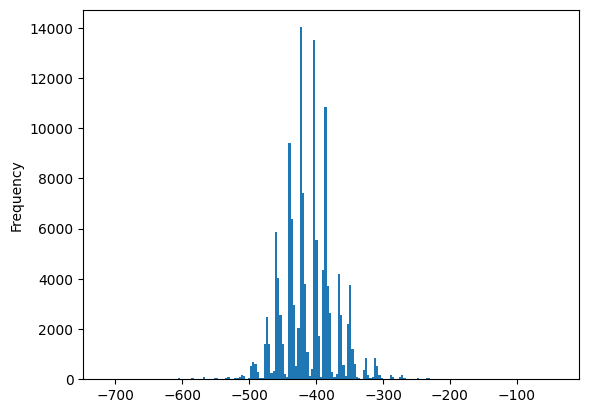

In [47]:
df=pd.read_csv("datasets/qm9/raw/gdb9.sdf.csv")
display(df.describe().T)
YCOL='u0'
#(df[YCOL].quantile([.01,.02,.03,.05,.5,.95,.97,.98,.99]))
__min=df[YCOL].quantile(.0001)
__max=df[YCOL].quantile(.9999)
__mean=df[YCOL].mean()
__std=df[YCOL].std()
df[YCOL].plot.hist(bins=200)
offset=(__min+__max)/2
width=abs(__max-__min)/2
offset,width

In [ ]:
import numpy as np
BATCH_SIZE=32
N_EPOCHS=100
N_mols=len(train_dataset)
long_bar=tqdm(range(N_EPOCHS*N_mols//BATCH_SIZE),smoothing=0)
e_bar=tqdm(range(N_mols//BATCH_SIZE),smoothing=0)
Q=100000
N_TRAINING_MODEL=len(models)
for model in models:
    model.inner=model.inner.train()
    model.stopped=False
    
#torch.autograd.set_detect_anomaly(True)
for epoch in range(N_EPOCHS):
    e_bar.refresh()
    e_bar.reset(N_mols//BATCH_SIZE)
    train_bl=DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    for i, batch in zip(range(N_mols//BATCH_SIZE), train_bl):
        long_bar.update(1)
        e_bar.update(1)
        try:
            batch=(batch.to(cuda))
            
            for model in models:
                if model.stopped or not model.training: continue
                model.inner=model.inner.train()
                out = model.inner(batch)
                extra_loss=0
                if isinstance(out, tuple):
                    out, extra_loss=out
                loss = ((out*__std+__mean-batch[YCOL])**2).mean()+extra_loss
                model.inner.zero_grad(set_to_none=True)
                
                if model.total_iters<5:
                    model.running_loss = model.running_loss*.3+loss.item()*.7
                else:
                    model.running_loss = model.running_loss*(1-1/100)+loss.item()/100
                    
                if model.total_iters+.2>1.1**len(model.train_loss_record):
                    model.train_loss_record[model.total_iters]=model.running_loss
                loss.backward()
                model.optim.step()
                model.total_iters+=1

            ### evaluation
            if i%32==0:
                for model in models:
                    if model.stopped or not model.training: continue
                    model.inner=model.inner.eval()
                    L=len(test_dataset)
                    test_bl=DataLoader(test_dataset, batch_size=L)
                    all_eval_y=list()
                    model.test_loss_record[model.total_iters]=0
                    for batch in test_bl:
                        batch=(batch.to(cuda))
                        all_eval_y+=batch[YCOL].view(-1).tolist()
                        with torch.no_grad():
                            out = model.inner(batch)#X, A, E, batch=b)
                            if isinstance(out, tuple):
                                out, _=out
                        model.results=out.view(-1).tolist()
                        loss = ((out*__std+__mean-batch[YCOL]).abs()).sum().detach().item()
                        model.test_loss_record[model.total_iters]+=loss/L
                    
                    if model.test_loss_record[model.total_iters]<model.best_eval_loss:
                        model.best_eval_loss=model.test_loss_record[model.total_iters]
                        if model.total_iters>10000:
                            model.save()
                        #if np.log10(loss/models[model_name]['best_eval_loss'])>1.5 and models[model_name]['total_iters']>100:
                        #    models[model_name]['stopped']=True
                        #    N_TRAINING_MODEL-=1
            ###logging
            logstr=''
            for model in models:
                if model.stopped:
                    logstr+=f'{model.name}(stopped):{int(Q*model.running_loss)/Q}({int(Q*model.best_eval_loss)/Q}). '
                else:
                    logstr+=f'{model.name}:{int(Q*model.running_loss)/Q}({int(Q*model.best_eval_loss)/Q}). '
            e_bar.set_description(logstr)
        except Exception as e:
            raise e
    ### stepping schedulers:
    
    for model in models:
        if model.sched is None: continue
        if model.stopped or not model.training: continue
        model.inner=model.inner.eval()
        L=len(test_dataset)
        test_bl=DataLoader(test_dataset, batch_size=L)
        total_eval_loss=0
        for batch in test_bl:
            batch=(batch.to(cuda))
            eval_y=(batch[YCOL]-__mean)/__std
            with torch.no_grad():
                out = model.inner(batch)#X, A, E, batch=b)
                if isinstance(out, tuple):
                    out, _=out
            loss = ((out-eval_y).abs()).sum().detach().item()
            total_eval_loss+=loss/L
        model.sched.step()

  0%|          | 0/411603 [00:00<?, ?it/s]

  0%|          | 0/4116 [00:00<?, ?it/s]

In [37]:
model.inner

QM9Regressor(
  (atom_emb): Embedding(200, 64)
  (unets): ModuleList(
    (0-2): 3 x UNet(
      (activation): SiLU()
      (downs): ModuleList(
        (0-3): 4 x DownSampler(
          (gauss): GaussianSmearing()
          (conv): ConvLayer()
          (norm): GraphNorm(64)
        )
      )
      (ups): ModuleList(
        (0-3): 4 x UpSampler(
          (conv): ConvLayer()
          (gauss): GaussianSmearing()
        )
      )
      (down_norms): ModuleList(
        (0-3): 4 x GraphNorm(64)
      )
      (up_norms): ModuleList(
        (0-3): 4 x GraphNorm(64)
      )
    )
  )
)

In [38]:
out

tensor([-52.6892, -37.7710, -69.0671, -37.8368, -45.1797, -59.7259, -51.5643,
        -43.4150, -55.4387, -33.9428, -83.1115, -42.7684, -55.1416,  -8.2797,
        -74.6718, -42.5277, -65.7413, -30.1682, -34.3769, -31.0287, -75.0142,
        -54.4015, -42.6130,   0.4807, -34.4269, -59.5253, -22.2995, -40.7741,
        -67.4187, -44.0374, -69.5282, -11.4092], device='cuda:0',
       grad_fn=<SumBackward1>)

In [41]:
batch.u0

tensor([-405.5599, -382.6054, -387.0468, -416.8701, -420.4649, -422.9843,
        -439.0317, -440.3035, -421.7949, -476.2469, -352.3575, -436.7056,
        -437.8705, -448.9181, -385.8275, -419.2387, -400.7570, -434.0748,
        -439.1047, -362.5703, -384.5775, -440.3046, -437.9566, -489.8797,
        -383.7417, -424.2003, -434.1044, -401.9162, -388.2587, -383.2213,
        -367.2304, -455.1707], device='cuda:0')